In [1]:
!pip install --upgrade tensorflow
!pip install gensim
!pip install paramiko
!pip install keras


Requirement already up-to-date: tensorflow in /opt/conda/lib/python3.7/site-packages (2.2.0)


In [2]:
# Import packages
import os
import time
import math
import copy
import keras
import random
import warnings
import numpy as np
import pandas as pd
from keras import *
from keras import layers
from gensim.models import *
from sklearn.metrics import *
from keras.models import Model
import matplotlib.pyplot as plt
from keras.preprocessing import *
from collections import defaultdict
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import Counter

# Matplotlib parameters
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [12, 8] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally

# Notebook style properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style> .output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 300%;}</style>"))

# Ignore warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

# Set random initialization seeds for reproducible results
from numpy.random import seed
seed(1)

Using TensorFlow backend.


# 1. Helper Functions
This cell contains all the miscellaneous functions that will be used throughout this notebook. A summary of each function is provided just below the function definition.

In [3]:
def getMetrics(trueLabels, predictedLabels, predictedLabelsProbabilities):
    """Takes as input true labels, predictions, and prediction confidence scores and computes all metrics"""
    
    aucScore = round(roc_auc_score(trueLabels, predictedLabelsProbabilities) * 100, 1)
    precisionLow = round(precision_score(trueLabels, predictedLabels, average=None)[0] * 100, 1)
    precisionHigh = round(precision_score(trueLabels, predictedLabels, average=None)[1] * 100, 1)
    recallLow = round(recall_score(trueLabels, predictedLabels, average=None)[0] * 100, 1)
    recallHigh = round(recall_score(trueLabels, predictedLabels, average=None)[1] * 100, 1)
    fpr, tpr, threshold = roc_curve(trueLabels, predictedLabelsProbabilities)
    
    return aucScore, precisionLow, precisionHigh, recallLow, recallHigh, fpr, tpr

def isnan(object):
    """Check for a null value"""
    return object != object

def removeNans(inputList):
    """Remove null values"""
    inputList = [item if isnan(item) == False else 0 for item in inputList]
    return inputList

def loadTabDelimitedDataForEmbeddings(dataPath):
    """Load data from a tab delimited file. Used for embeddings"""
    data = pd.DataFrame(pd.read_csv(dataPath, "\t"))["Word"].values.tolist()
    return data

def splitRowIntoWords(row, length):
    """Takes a variable length text input and convert it into a list of words with length equal to 'length' in the function parameter"""
    words = keras.preprocessing.text.text_to_word_sequence(row, filters=' !#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n"\'', lower=True, split=" ")
    
    # If length is less than required length, add zeros
    while len(words) < length:
        words.append(0)
        
    # If greater, remove stuff at the end
    if len(words) >= length:
        words = words[:length]
        
    return words

def convertCharDataIntoArrays(inputText, characters, charsDict, MAX_CHARACTERS_TO_KEEP):
    """Takes as input a list of text rows and convert each text row into a list of character embeddings"""
    characterFeatures = []
    for row in inputText:
        characterFeature = np.zeros((MAX_CHARACTERS_TO_KEEP, len(characters)+1))
        for c in range(0, min(len(row), MAX_CHARACTERS_TO_KEEP)):
            character = row[c]
            # Explicitly converting each character into a character embedding i.e just a one hot encoded representation
            charPresence = np.zeros(len(characters)+1)
            
            # Add 1 where the character is present
            if character in charsDict:
                charPresence[charsDict[character]] = 1
                characterFeature[c] = charPresence
                
        characterFeatures.append(characterFeature)

    return np.array(characterFeatures)

def joinRepresentations(representationList):
    """Takes multiple forms of text input and concatenate them together."""
    joinedReprsentations = ''.join(str(representation) + "\t" for representation in representationList)
    return joinedReprsentations

def removeNan(inputList):
    """Remove null values from input"""
    copiedList = list(inputList)
    if isnan(copiedList[-1]) == True:
        del copiedList[-1]
        
    return copiedList

def normalizeStructuredData(drugDict, inputList):
    """Takes as input a drug list(drugDict) and a structure array list and converts variables into nominal and categorical variables"""
    
    drug = inputList[0]
    gender = inputList[1]
    age = inputList[2]
    days = inputList[3]
    
    drugArray = [0] * (len(drugDict) + 1) # convert drug into a categorical variable (one hot encoding of a drug)
    if drug in drugDict:
        drugArray[drugDict[drug]] = 1
        
    age = float(age / 100)
    
    # convert gender into a categorical variable
    if gender == 1:
        genderArray = [1,0]
    else:
        genderArray = [0,1]
    
    # if more than 1000 days, this just keeps them to 1000
    days = days / 1000
    if days >= 1:
        days = 1
    
    # add normalized data to a new list and return that list
    normalizedList = []
    normalizedList.extend(drugArray)
    normalizedList.extend(genderArray)
    normalizedList.append(age)
    normalizedList.append(days)
    
    return normalizedList
    
def addText(xticks, yticks, results):
    """Add text in the plot"""
    for i in range(2):
        for j in range(2):
            pltText = plt.text(j, i, results[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap    
    
    
def displayConfusionMatrix(confusionMatrix):
    """Confusion matrix plot"""
    
    confusionMatrix = np.transpose(confusionMatrix)
    
    ## calculate class level precision and recall from confusion matrix
    precisionLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[0][1]))*100, 1)
    precisionHigh = round((confusionMatrix[1][1] / (confusionMatrix[1][0] + confusionMatrix[1][1]))*100, 1)
    recallLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[1][0]))*100, 1)
    recallHigh = round((confusionMatrix[1][1] / (confusionMatrix[0][1] + confusionMatrix[1][1]))*100, 1)

    ## show heatmap
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues,vmin=0, vmax=100)
    
    ## axis labeling
    PLOT_FONT_SIZE = 14
    xticks = np.array([-0.5,0,1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["","LowSev \n Recall=" + str(recallLow), "HighSev \n Recall=" + str(recallHigh),""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["","LowSev \n Precision=" + str(precisionLow), "HighSev \n Precision=" + str(precisionHigh),""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)

    ## add text in heatmap boxes
    addText(xticks, xticks, confusionMatrix)

# 2. Data Loading
## 2.1 Loading Text Data
There are two different types of data inputs for these models.
1. Text
2. Structured Variables


In [4]:
start = time.time()
delimiter = "\t"
 
# Load files
inputDataTrain = pd.DataFrame(pd.read_csv("TextFiles/train_DrugExp_Text.tsv", delimiter, header=None))
inputDataTest = pd.DataFrame(pd.read_csv("TextFiles/test_DrugExp_Text.tsv", delimiter, header=None))
inputDataValidation = pd.DataFrame(pd.read_csv("TextFiles/validation_DrugExp_Text.tsv", delimiter, header=None))

## display some text
print(inputDataTrain.values.tolist()[5])

## extract text from data frames
trainText = [item[1] for item in inputDataTrain.values.tolist()]
testText = [item[1] for item in inputDataTest.values.tolist()]
validationText = [item[1] for item in inputDataValidation.values.tolist()]

## extract labels
trainingLabels = [0 if item[0] == -1 else 1 for item in inputDataTrain.values.tolist()]
validationLabels = [0 if item[0] == -1 else 1 for item in inputDataValidation.values.tolist()]

print("Total number of rows", len(trainText), len(testText), len(validationText))
print("Data loading took %d seconds" % (time.time() - start))

[-1, 'Osteoporosis in spine Took 1 dose and by that evening had flu-like symptoms and fever, but that was not the worst part. By the next morning I experienced such bad back spasms that I literally could not even sit up in bed. I ended up being transported by ambulance to the ER where the doctors spent the day ruling out other possible problems. I have never experienced anything like this before. I am exploring other healthy and natural treatment options - increasing my intake of Calcium and Vitamin D through supplements and diet. I will not take that product again!']
Total number of rows 8163 2380 1360
Data loading took 0 seconds


## 2.2 Exploring text data entries

In [5]:
print(inputDataTrain.values.tolist()[8162])

[-1, 'hiper activities back pain chest pain']


In [53]:
asresults = Counter()
inputDataTrain[1].str.lower().str.split().apply(asresults.update)
print (asresults.most_common(100))

[('i', 40199), ('and', 23611), ('the', 23486), ('to', 20516), ('my', 15061), ('a', 14428), ('it', 14372), ('of', 12254), ('for', 9450), ('was', 9010), ('have', 8782), ('this', 8560), ('in', 8114), ('on', 6609), ('that', 6380), ('is', 6343), ('not', 5981), ('me', 5969), ('but', 5902), ('had', 5418), ('with', 5412), ('after', 3918), ('so', 3879), ('side', 3656), ('no', 3496), ('take', 3440), ('t', 3426), ('at', 3411), ('taking', 3381), ('am', 3298), ('as', 3249), ('all', 3164), ('pain', 3112), ('be', 3032), ('day', 3004), ('effects', 2969), ('been', 2957), ('drug', 2879), ('like', 2870), ('if', 2795), ('you', 2792), ('has', 2546), ('very', 2544), ('days', 2512), ('about', 2498), ('now', 2496), ('get', 2493), ('or', 2429), ('from', 2367), ('when', 2342), ('would', 2238), ('weight', 2234), ('out', 2177), ('feel', 2098), ('time', 2086), ('up', 2075), ('just', 2062), ('can', 2062), ('are', 2048), ('back', 2044), ('only', 2018), ('off', 1971), ('first', 1945), ('will', 1921), ('2', 1920), ('d

In [64]:
charvaluecount = inputDataTrain[1].str.len()
print(charvaluecount.min())
print(charvaluecount.mean())
print(np.percentile(charvaluecount, 95))


0        453
1        817
2        373
3        854
4        117
        ... 
8158     503
8159    1449
8160     277
8161     349
8162      37
Name: 1, Length: 8163, dtype: int64
20
535.3676344481196
1287.7999999999993


## 2.3 Loading Structured Data

In [8]:
start = time.time()
delimiter = "\t"

STRUCTURED_DATA_FILE = "_DrugExp_Structured.tsv"
inputDataTrainStructured = pd.DataFrame(pd.read_csv("StructuredDataFiles/train" + STRUCTURED_DATA_FILE, delimiter, header=None))
inputDataTestStructured = pd.DataFrame(pd.read_csv("StructuredDataFiles/test" + STRUCTURED_DATA_FILE, delimiter, header=None))
inputDataValidationStructured = pd.DataFrame(pd.read_csv("StructuredDataFiles/validation" + STRUCTURED_DATA_FILE, delimiter, header=None))

## display structure
print(inputDataTrainStructured.values.tolist()[5])

## extract frn features from data frames
allDrugs = list(sorted(list(set([item[1] for item in inputDataTrainStructured.values.tolist()]))))
allDrugs = dict([(allDrugs[index], index) for index in range(0, len(allDrugs))])

trainStructured = np.array([normalizeStructuredData(allDrugs,item[1:]) for item in inputDataTrainStructured.values.tolist()])
testStructured = np.array([normalizeStructuredData(allDrugs,item[1:]) for item in inputDataTestStructured.values.tolist()])
validationStructured = np.array([normalizeStructuredData(allDrugs,item[1:]) for item in inputDataValidationStructured.values.tolist()])

print("Data shape", trainStructured.shape, testStructured.shape, validationStructured.shape)
print("Total number of rows", len(trainStructured), len(testStructured), len(validationStructured))
print("Data loading took %d seconds" % (time.time() - start))

[-1, 'ACTONEL', 1, 57, 1]
Data shape (8163, 222) (2380, 222) (1360, 222)
Total number of rows 8163 2380 1360
Data loading took 0 seconds


In [9]:
print(inputDataTrainStructured.head())

   0        1  2   3  4
0 -1  ABILIFY  1  47  1
1 -1  ACTONEL  1  54  1
2 -1  ACTONEL  1  63  1
3 -1  ACTONEL  1  41  1
4 -1  ACTONEL  1  54  1


# 3. Create Word Embeddings
Word2vec is a powerful algorithm for creating word embeddings. My models toggle between using my own embeddings and the ones built-in keras (keras.layers.Embedding) function.

In [10]:
# Input file for creating word embeddings
delimiter = "\t"
INPUT_FILE = "TextFiles/train_DrugExp_Text.tsv"
INPUT_DATA = pd.DataFrame(pd.read_csv("TextFiles/train_DrugExp_Text.tsv", delimiter, header=None)).values.tolist()

# Hyperparameters for word embeddings
OUTPUT_EMBEDDING_FILE_NAME = "Embeddings/WordEmbeddings.txt"
WINDOW_SIZE = 5
EMBEDDING_DIMENSION = 128
MIN_FREQUENCY_THRESHOLD = 2
IS_SKIPGRAM = 1 # 0 will use continuous bag of words (CBOW) model
IS_LOWER_WORDS = True
ITERATIONS = 25 # iterations used in creating word embeddings

# Convert data into a list of words
rowWords = []
for row in INPUT_DATA:
    rowText = row[1]
    words  = keras.preprocessing.text.text_to_word_sequence(rowText, filters=' !#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n"\'', lower=IS_LOWER_WORDS, split=" ") #ignoring the punctuations
    rowWords.append(words)

# Train model
start = time.time()
model = word2vec.Word2Vec(rowWords, size=EMBEDDING_DIMENSION,window=WINDOW_SIZE, min_count=MIN_FREQUENCY_THRESHOLD, sg=IS_SKIPGRAM, workers=8, iter=ITERATIONS)

# Save model
model.wv.save_word2vec_format(OUTPUT_EMBEDDING_FILE_NAME)
os.system("sed -i '1d' " + OUTPUT_EMBEDDING_FILE_NAME) ## delete first column of the embedding
print('Your embeddings have been created in %.2f seconds' % (time.time() - start))

Your embeddings have been created in 37.00 seconds


# 4. Data Preparation for Deep Learning Models
Different deep learning models take different forms of data as input. For instance, character CNN takes as input one-hot encoded character representations while word CNN uses word representations. The functions below will load the data for different deep learning models.

## 4.1 Loading Data for Word Based Models

In [1]:
def loadDataForWordsWithoutPreTrainedEmbeddings(trainText, validationText, testText, VOCABULARY_SIZE):
    """This function takes as input three text files and a vocabulary size (words to keep in the model) 
    and returns lists containing word ids and the total number of words for the model.
    The word ids will be used the keras.layers.Embedding function to create word embeddings"""
    
    # If vocabulary size is not defined, use all words
    if VOCABULARY_SIZE == None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(trainText)
        WORDS_TO_KEEP = len(tokenizer.word_index)
        
    # Delete words based on frequency and keep words equal to the vocabulary size
    else:
        tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
        tokenizer.fit_on_texts(trainText)
        WORDS_TO_KEEP = VOCABULARY_SIZE
    
    ## convert words into word ids
    meanLength = np.mean([len(item.split(" ")) for item in trainText])
    MAX_SENTENCE_LENGTH = int(meanLength + 100) # this lets a sentence go 100 words longer than the mean sentence length.
    
    ## convert train, validation, and test text into lists with word ids
    trainWordFeatures = tokenizer.texts_to_sequences(trainText)
    trainWordFeatures = pad_sequences(trainWordFeatures, MAX_SENTENCE_LENGTH, padding='post')

    validationWordFeatures = tokenizer.texts_to_sequences(validationText)
    validationWordFeatures = pad_sequences(validationWordFeatures, MAX_SENTENCE_LENGTH, padding='post')

    testWordFeatures = tokenizer.texts_to_sequences(testText)
    testWordFeatures = pad_sequences(testWordFeatures, MAX_SENTENCE_LENGTH, padding='post')
    
    return trainWordFeatures, validationWordFeatures, testWordFeatures, WORDS_TO_KEEP

def loadDataForWordsWithPreTrainedEmbeddings(trainText, validationText, testText, EMBEDDING_PATH):
    """This function takes as input three text files and and a pre-trained word embedding file and 
    returns arrays containing word embeddings for each word in the text. These arrays can be used 
    directly in a keras model without the use of keras.layers.Embedding layer."""
    
    # Load embeddings
    embeddingsData = pd.DataFrame(pd.read_csv(EMBEDDING_PATH, " ")).values.tolist()
    embeddingsDataDictionary = dict([(item[0], item[1:len(item)-1]) for item in embeddingsData]) # create dictionary of key=word, value=word embedding from the embedding file
    EMBEDDING_SIZE = int(len(embeddingsDataDictionary[random.choice(list(embeddingsDataDictionary.keys()))]))
    
    ## convert words into word ids
    meanLength = np.mean([len(item.split(" ")) for item in trainText])
    MAX_SENTENCE_LENGTH = int(meanLength + 100) # we let a sentence go 100 words longer than the mean sentence length.
    
    ## convert train, validation, and test text into lists with word ids
    trainTextWords = [splitRowIntoWords(row, MAX_SENTENCE_LENGTH) for row in trainText]
    trainWordFeatures = []
    for row in trainTextWords:
        rowEmbeddings = [embeddingsDataDictionary[word] if word in embeddingsDataDictionary else [0]*EMBEDDING_SIZE for word in row]
        trainWordFeatures.append(rowEmbeddings)

    validationTextWords = [splitRowIntoWords(row, MAX_SENTENCE_LENGTH) for row in validationText]
    validationWordFeatures = []
    for row in validationTextWords:
        rowEmbeddings = [embeddingsDataDictionary[word] if word in embeddingsDataDictionary else [0]*EMBEDDING_SIZE for word in row]
        validationWordFeatures.append(rowEmbeddings)

    testTextWords = [splitRowIntoWords(row, MAX_SENTENCE_LENGTH) for row in testText]
    testWordFeatures = []
    for row in testTextWords:
        rowEmbeddings = [embeddingsDataDictionary[word] if word in embeddingsDataDictionary else [0]*EMBEDDING_SIZE for word in row]
        testWordFeatures.append(rowEmbeddings)
    
    return np.array(trainWordFeatures), np.array(validationWordFeatures), np.array(testWordFeatures), None

## 4.2 Loading data for Character based Models

In [12]:
def loadDataForChars(trainText, validationText, testText, MAX_CHARACTERS_TO_KEEP, USE_UPPER_CASE_CHARACTERS=True):
    """Create input feature lists for character based models"""
    
    # create characters string based on the set parameter. This keeps punctuation as well
    if USE_UPPER_CASE_CHARACTERS:
        characters = " ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-,'.!?();:-_=+@#$%^&*/\""
    else:
        characters = " abcdefghijklmnopqrstuvwxyz0123456789-,'.!?();:-_=+@#$%^&*/\""
    
    charsDict = {}
    numsDict = {}

    ## assign an id to each character
    for c in range(0,len(characters)):
        charsDict[characters[c]] = c+1
        numsDict[c+1] = characters[c]

    ## create feature vectors for each row of text (Train)
    characterFeaturesTrain = convertCharDataIntoArrays(trainText, characters, charsDict, MAX_CHARACTERS_TO_KEEP) 

    ## create feature vectors for each row of text (Test)
    characterFeaturesTest = convertCharDataIntoArrays(testText, characters, charsDict, MAX_CHARACTERS_TO_KEEP) 

    ## create feature vectors for each row of text (Validation)
    characterFeaturesValidation = convertCharDataIntoArrays(validationText, characters, charsDict, MAX_CHARACTERS_TO_KEEP) 

    return characterFeaturesTrain, characterFeaturesValidation, characterFeaturesTest

# 5. Deep Learning Models
## 5.1 Word Convolutional Neural Network

In [13]:
def createWordCNN(trainFeatures, validationFeatures, testFeatures, numConvLayers, vocabularyWords, embeddingsDimensionality, numFilters, kernel, isPreTrainedEmbeddings): 
    """Create a word cnn"""
    
    ## Creates Basic Word CNN Model
    wordInput = Input(shape=trainFeatures.shape[1:], dtype='float32')
 
    ## Word Convolutional Neural Network
    if isPreTrainedEmbeddings == False:
        # Creates embeddings using keras built in function.
        wordCNN = keras.layers.Embedding(input_dim=vocabularyWords + 1, 
                                   output_dim=embeddingsDimensionality, 
                                   input_length=len(trainFeatures[0]))(wordInput)
    
        # Adds CNN layers equal to numConvLayers
        for i in range(numConvLayers):
            wordCNN = keras.layers.Conv1D(numFilters, kernel, activation='relu')(wordCNN)
            wordCNN = keras.layers.Dropout(0.5)(wordCNN)
    else:
        
        # Using Pre-Trained Embeddings for this model. Therefore, don't need to call layers.embeddings function.
        wordCNN = keras.layers.Conv1D(numFilters, kernel, activation='relu', input_shape=trainFeatures.shape[1:])(wordInput)
        wordCNN = keras.layers.Dropout(0.2)(wordCNN)
        for i in range(numConvLayers - 1):
            wordCNN = keras.layers.Conv1D(numFilters, kernel, activation='relu')(wordCNN)
            wordCNN = keras.layers.Dropout(0.5)(wordCNN)
    
    # GlobalMaxPooling is a good function to use for pooling operations
    wordCNN = keras.layers.GlobalMaxPooling1D()(wordCNN)
    wordCNN = keras.layers.Dropout(0.2)(wordCNN)
    
    # Dense Layer
    denseLayer = keras.layers.Dense(128)(wordCNN)
    
    return denseLayer, wordInput

## 5.3 Character Convolutional Neural Network

In [15]:
def createCharCNN(trainFeatures, validationFeatures, testFeatures, numConvLayers, numFilters, kernel): 
    """Create a char cnn"""
    
    ## create Basic CNN model
    charInput = Input(shape=trainFeatures.shape[1:], dtype='float32')
 
    # Here, Use one hot encoded representation of characters. Therefore, there's no need to call layers.embeddings function.
    charCNN = keras.layers.Conv1D(numFilters, kernel, activation='relu', input_shape=trainFeatures.shape[1:])(charInput)
    charCNN = keras.layers.Dropout(0.5)(charCNN)
    for i in range(numConvLayers - 1):
        charCNN = keras.layers.Conv1D(numFilters, kernel, activation='relu')(charCNN)
        charCNN = keras.layers.Dropout(0.2)(charCNN)
    
    charCNN = keras.layers.GlobalMaxPooling1D()(charCNN)
    
    #Dense Layer
    denseLayer = keras.layers.Dense(128)(charCNN)
    
    return denseLayer, charInput

## 5.4 Feed Forward Neural Network

In [16]:
def createFeedForwardNeuralNetwork(trainFeatures, validationFeatures, testFeatures, numLayers, layerNodes): 
    """Create a feed forward neural network"""
    
    ## Create Basic Feed Forward Neural Network model
    modelInput = Input(shape=trainFeatures.shape[1:], dtype='float32')
    neuralNetworkLayer = keras.layers.Dense(layerNodes, activation='relu', input_shape=trainFeatures.shape[1:])(modelInput)
    neuralNetworkLayer = keras.layers.Dropout(0.5)(neuralNetworkLayer)
    for i in range(numLayers - 1):
        neuralNetworkLayer = keras.layers.Dense(layerNodes, activation='relu')(neuralNetworkLayer)
        neuralNetworkLayer = keras.layers.Dropout(0.5)(neuralNetworkLayer)
    
    # Dense Layer
    denseLayer = keras.layers.Dense(32)(neuralNetworkLayer)
    
    return denseLayer, modelInput

# 6. Helper Functions for Deep Learning Models

In [17]:
def concatenateModels(modelDenseLayers):
    """Get a list if dense layers and concatenate them together"""
    concatenatedModel = keras.layers.concatenate(modelDenseLayers)
    
    """You can add more layers here after the concatenation of models e.g you can add single/multiple dense layers after the concatenation layer to give the model more power"""
    return concatenatedModel

def attachOutputLayerToModel(lastDenseLayer, modelInputs):
    """Take as input a dense layer and attach an output layer"""
    output = keras.layers.Dense(1, activation='sigmoid')(lastDenseLayer)
    model = Model(inputs=modelInputs, outputs=output)
    return model

def buildAndTrainModel(model, learningRate, batchSize, epochs, trainingData, validationData, testingData, trainingLabels, validationLabels, MODEL_NAME, isPrintModel=True):
    """Take the model and model parameters, build and train the model"""
    
    # Build and compile model
    # To use other optimizers, refer to: https://keras.io/optimizers/
    
    optimizer = optimizers.Adam(lr=learningRate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    if isPrintModel:
        print(model.summary())
        
    # Train model
    aucScore, precisionLow, precisionHigh, recallLow, recallHigh, fpr, tpr = None, None, None, None, None, None, None ##initializing best test metrics
    confusionMatrix = None
    bestValidationAccuracy = 0.0
    bestTestModel = None


    rocCurvesData = {}
    for epoch in range(0, epochs):
        model.fit(trainingData, trainingLabels,
                        epochs=1,
                        verbose=0,
                        batch_size=batchSize,
                        shuffle=False)
        
        # Evaluate model
        trainLoss, trainAccuracy = model.evaluate(trainingData, trainingLabels, verbose=False)
        valLoss, valAccuracy = model.evaluate(validationData, validationLabels, verbose=False)
        
        # Get Metrics
        predictionsProbs = model.predict(validationData)
        predictions = [1 if value >= 0.5 else 0 for value in predictionsProbs]
        predictionsProbs = [value for value in predictionsProbs]
        aucScoreEpoch, _, _, _, _, fprEpoch, tprEpoch = getMetrics(validationLabels, predictions, predictionsProbs)
        rocCurvesData[epoch] = {"fpr":fprEpoch, "tpr":tprEpoch, "auc":aucScoreEpoch}
        
        print('Epoch: %d \nTraining: %.3f \nValidation: %.3f\n' % (epoch, trainAccuracy, valAccuracy))
        if valAccuracy >= bestValidationAccuracy:
            
            bestValidationAccuracy = float(valAccuracy)
            
            ## Get Metrics
            predictionsProbs = model.predict(validationData)
            predictions = [1 if value >= 0.5 else 0 for value in predictionsProbs]
            predictionsProbs = [value for value in predictionsProbs]
            aucScore, precisionLow, precisionHigh, recallLow, recallHigh, fpr, tpr = getMetrics(validationLabels, predictions, predictionsProbs)
            confusionMatrix = confusion_matrix(validationLabels, predictions)
            
           #### STORE PREDICTIONS ######
            print("Writing test predictions for kaggle for epoch %d" % epoch)
            predictionsProbsTest = model.predict(testingData)
            predictionsFile = open("AllModelsPredictions/" + str(MODEL_NAME) + "_predictions.txt", "w")
            predictionsFile.write("Id,Prediction\n")
            for i in range(0, len(predictionsProbsTest)):
                predictionsFile.write(str(i+1) + "," + str(predictionsProbsTest[i][0]) + "\n")
            predictionsFile.close()
            
            
    # Results dictionary contains all the best test results. These can be used to build ROC plots, ROC Variance plots, and more.
    resultsDictionary = {"confusionMatrix":confusionMatrix, "bestTestAccuracy":bestValidationAccuracy, "bestAucScoreTest":aucScore, "bestPrecisionLowTest":precisionLow, "bestPrecisionHighTest":precisionHigh,
                        "recallLowTest":recallLow, "recallHighTest":recallHigh, "FalsePositiveRateTest":fpr, "TruePositiveRateTest":tpr}
    
    return resultsDictionary, rocCurvesData

def createROCCurve(resultsDictionary, rocCurveTitle, color):
    """Create ROC curve from resultsDictionary that is returned from the above function"""
    
    fpr = resultsDictionary["FalsePositiveRateTest"]
    tpr = resultsDictionary["TruePositiveRateTest"]
    plt.plot(fpr, tpr, linewidth=3.0, color=color)
    
def createROCCurvesForAllEpochs(rocCurvesForAllEpochs, title, isVarianceCurve = True):
    """Create a ROC Variance Curve"""
    
    epochs = list(sorted(list(rocCurvesForAllEpochs.keys())))
    
    # Calculate min and max auc score from all epochs
    maxAuc = max(list([item["auc"] for item in rocCurvesForAllEpochs.values()]))
    minAuc = min(list([item["auc"] for item in rocCurvesForAllEpochs.values()]))
    
    for epoch in epochs:
        fprs = rocCurvesForAllEpochs[epoch]["fpr"]
        tprs = rocCurvesForAllEpochs[epoch]["tpr"]
        auc = rocCurvesForAllEpochs[epoch]["auc"]
                                
        if auc != maxAuc and auc != minAuc and isVarianceCurve == True:
            # alpha is the value of how transparent a line is
            plt.plot(fprs, tprs, linewidth=3.0, alpha=0.2)
        else:
            plt.plot(fprs, tprs, linewidth=3.0, alpha=1.0)

    FONT_SIZE = 14
    plt.legend(epochs, fontsize=FONT_SIZE)
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
    plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
    plt.title("ROC Variance Curve", fontsize=FONT_SIZE + 2)
    plt.show()

# 7 Fusing Multiple Deep Learning Models
Given the power of neural networks, it is usually better to combine a bunch of different models and fuse/ensemble them together to get better results.

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 201)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 201, 64)      320064      input_38[0][0]                   
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 201, 127)     0                                            
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 193, 512)     295424      embedding_9[0][0]                
___________________________________________________________________________________________

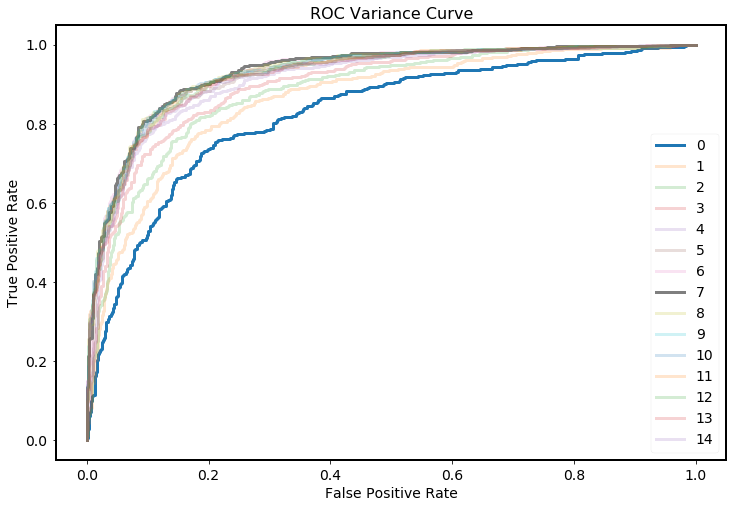

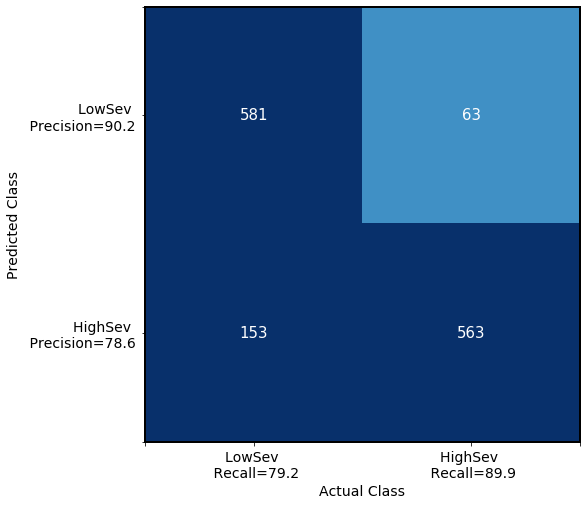

In [67]:
#### STRUCTURED NN MODEL
# Assign feature arrays to new arrays (just for consistent naming)
trainFeaturesStructured, validationFeaturesStructured, testFeaturesStructured = trainStructured, validationStructured, testStructured

# Build model
denseLayerStructured, modelInputStructured = createFeedForwardNeuralNetwork(trainFeaturesStructured, validationFeaturesStructured, testFeaturesStructured, 1, 128)

### KERAS EMBEDDINGS WORD CNN MODEL
VOCABULARY_SIZE = 5000
trainFeaturesWordCNN, validationFeaturesWordCNN, testFeaturesWordCNN, WORDS_TO_KEEP = loadDataForWordsWithoutPreTrainedEmbeddings(trainText, validationText, testText, VOCABULARY_SIZE)

# Build Keras Embeddings WordCNN model
EMBEDDINGS_DIMENSIONALITY = 64
FILTERS_SIZE = 512
KERNEL_SIZE = 9
NUM_CNN_LAYERS = 1
wordCNNDenseLayer, wordCNNInput = createWordCNN(trainFeaturesWordCNN, validationFeaturesWordCNN, testFeaturesWordCNN, NUM_CNN_LAYERS, WORDS_TO_KEEP, EMBEDDINGS_DIMENSIONALITY, FILTERS_SIZE, KERNEL_SIZE, isPreTrainedEmbeddings=False)


#CHARACTER CNN MODEL
MAX_CHARACTERS_TO_KEEP = 1200
USE_UPPER_CASE_CHARACTERS = False
trainFeaturesChar, validationFeaturesChar, testFeaturesChar = loadDataForChars(trainText, validationText, testText, MAX_CHARACTERS_TO_KEEP, USE_UPPER_CASE_CHARACTERS)

# Build CharCNN model
FILTERS_SIZE2 = 128
KERNEL_SIZE2 = 5
charCNNDenseLayer, charCNNInput = createCharCNN(trainFeaturesChar, validationFeaturesChar, testFeaturesChar, NUM_CNN_LAYERS, FILTERS_SIZE2, KERNEL_SIZE2)


#Representational Embeddings WORD CNN MODEL
EMBEDDING_PATH = "RepresentationEmbeddings/adrEmbeddings.txt"
ptCNNtrainFeatures, ptCNNvalidationFeatures, ptCNNtestFeatures, WORDS_TO_KEEP = loadDataForWordsWithPreTrainedEmbeddings(trainText, validationText, testText, EMBEDDING_PATH)

# Build Representational Embeddings WordCNN model
FILTERS_SIZE3 = 512
EMBEDDINGS_DIMENSIONALITY3 = 64 # this won't affect anything in a pre-trained embedding model
KERNEL_SIZE3 = 5
NUM_CNN_LAYERS3 = 1
ptCNNDenseLayer, ptCNNInput = createWordCNN(ptCNNtrainFeatures, ptCNNvalidationFeatures, ptCNNtestFeatures, NUM_CNN_LAYERS, WORDS_TO_KEEP, EMBEDDINGS_DIMENSIONALITY3, FILTERS_SIZE3, KERNEL_SIZE3, isPreTrainedEmbeddings=True)

# Output Layer to Attach to Model
wordCNNModel = attachOutputLayerToModel(ptCNNDenseLayer, ptCNNInput)


# FUSION OF MODELS
# Concatenates models together. This will make the model leverage all individual models during training. 
# Call the 'concatenateModels' function that takes as parameter a list of dense layers from different neural networks and concatenates them together
concatenatedDenseLayer = concatenateModels([denseLayerStructured, wordCNNDenseLayer, charCNNDenseLayer, ptCNNDenseLayer])

# Attach the output layer to the concatenated model. Pass the concatenated layer to the first argument and a list of inputs of concatenated models to the second argument
concatenatedCNNModel = attachOutputLayerToModel(concatenatedDenseLayer, [modelInputStructured, wordCNNInput, charCNNInput, ptCNNInput])

#TRAIN MODEL
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 15

# Pass feature lists from concatenated models
# The order of the input is very important here. During concatenation, the order in the input list has to be the same as the training while inputting the training, testing, and validation inputs.
concatenatedModelResults, epochLevelResultsCombinedModel = buildAndTrainModel(concatenatedCNNModel, LEARNING_RATE, BATCH_SIZE, EPOCHS, [trainFeaturesStructured, trainFeaturesWordCNN, trainFeaturesChar, ptCNNtrainFeatures], 
                                              [validationFeaturesStructured, validationFeaturesWordCNN, validationFeaturesChar, ptCNNvalidationFeatures], 
                                                                              [testFeaturesStructured, testFeaturesWordCNN, testFeaturesChar, ptCNNtestFeatures], trainingLabels, validationLabels, "combinedModel")

# Results
bestTestAUC = concatenatedModelResults["bestAucScoreTest"]
bestTestAccuracy = concatenatedModelResults["bestTestAccuracy"]
print('Best Test Accuracy: %.3f \nBest Test AUC: %.3f' % (bestTestAccuracy, bestTestAUC))

#ROC Curve
plt.rcParams['figure.figsize'] = [12, 8] ## plot size
createROCCurvesForAllEpochs(epochLevelResultsCombinedModel, "Fusion Model", isVarianceCurve = True)
#Conf Matrix
plt.cla()
plt.clf()
confusionMatrix = concatenatedModelResults["confusionMatrix"]
displayConfusionMatrix(confusionMatrix)
plt.show()

## 8.2 Ensembling Models
Fusion Model will be ensembled with a Word CNN with Word Embeddings.

In [68]:
modelOnePredictions = pd.DataFrame(pd.read_csv("AllModelsPredictions/WordCNNWithoutPretrainedEmbeddings_predictions.txt", ",")).values.tolist()
modelTwoPredictions = pd.DataFrame(pd.read_csv("AllModelsPredictions/combinedModel_predictions.txt", ",")).values.tolist()
weightOne = 0.5
weightTwo = 0.5


"""To add more models, just add a few more lines and use them during average. For instance, adding a third model would require 2 more lines above. modelThreePredictions and weightThree. Next, you only need to 
use the predictions from that during averaging below. You will have 'average = (weightOne * modelOnePredictions[i][1]) + (weightTwo * modelTwoPredictions[i][1]) + (weightThree * modelThreePredictions[i][1])' """


averagePredictions = []

for i in range(0, len(modelOnePredictions)):
    average = (weightOne * modelOnePredictions[i][1]) + (weightTwo * modelTwoPredictions[i][1])
    averagePredictions.append(average)
    
averageHardPredictions = [1 if item >= 0.5 else 0 for item in averagePredictions]

# Create file for kaggle submission
kaggleFile = open("AllModelsPredictions/ensemble_predictions.txt","w")
kaggleFile.write("Id,Prediction\n")
for i in range(0, len(averagePredictions)):
    kaggleFile.write(str(i+1) + "," + str(averagePredictions[i]) + "\n")
kaggleFile.close()